In [1]:
from typing import List, Tuple, Any, Optional

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(32)

In [3]:
class Bandit:
    def __init__(self, mu: float, std: float, Q: float = 0.0, alpha: float = 0.1):
        self._mu = mu
        self._std = std
        self._Q = Q
        self._alpha = alpha
        self._o = 0

    def pull(self) -> float:
        return np.random.normal(loc=self._mu, scale=self._std)

    def update(self, r: float):
        self._o += self._alpha * (1 - self._o)
        beta = self._alpha / self._o
        self._Q += beta * (r - self._Q)

    @property
    def true_val(self):
        return self._mu

    @property
    def Q(self):
        return self._Q

In [4]:
def single_run(
    bandits: List[Bandit], n_steps: int, eps: float
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:

    rewards = np.zeros(n_steps)
    optimals = np.zeros(n_steps)
    selected_actions = np.zeros(n_steps)

    optimal_bandit = int(np.argmax([b.true_val for b in bandits]))

    for i in range(n_steps):

        if np.random.rand() < eps:
            bandit = np.random.choice(len(bandits))
        else:
            bandit = np.argmax([b.Q for b in bandits])

        bandit = int(bandit)

        r = bandits[bandit].pull()
        bandits[bandit].update(r)

        rewards[i] = r
        optimals[i] = 1 if bandit == optimal_bandit else 0
        selected_actions[i] = bandit

    return rewards, optimals, selected_actions

In [5]:
def run_experiment(
    true_means: np.ndarray[float],
    true_sigmas: np.ndarray[float],
    n_runs: int,
    n_steps: int,
    eps: float = 0.1,
    alpha=0.1,
    Q: float = 0,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:

    all_rewards = np.zeros((n_runs, n_steps))
    all_optimals = np.zeros((n_runs, n_steps))
    all_selected_actions = np.zeros((n_runs, n_steps))

    for i in range(n_runs):
        bandits = [
            Bandit(mu=mu, std=sigma, Q=Q, alpha=alpha)
            for (mu, sigma) in zip(true_means, true_sigmas)
        ]
        rewards, optimals, selected_actions = single_run(
            bandits=bandits, n_steps=n_steps, eps=eps
        )

        all_rewards[i] = rewards
        all_optimals[i] = optimals
        all_selected_actions[i] = selected_actions

    return all_rewards.mean(axis=0), all_optimals.mean(axis=0), all_selected_actions

In [6]:
K = 10
N_RUNS = 2000
N_STEPS = 1000
MEANS = np.random.randn(K)
SIGMAS = np.random.rand(K)

In [16]:
exp_r_1, exp_o_1, exp_a_1 = run_experiment(
    true_means=MEANS, true_sigmas=SIGMAS, n_runs=N_RUNS, n_steps=N_STEPS, eps=0.0, Q=5
)
exp_r_2, exp_o_2, exp_a_2 = run_experiment(
    true_means=MEANS, true_sigmas=SIGMAS, n_runs=N_RUNS, n_steps=N_STEPS, eps=0.01, Q=5
)

exp_r_3, exp_o_3, exp_a_3 = run_experiment(
    true_means=MEANS, true_sigmas=SIGMAS, n_runs=N_RUNS, n_steps=N_STEPS, eps=0.1, Q=5
)

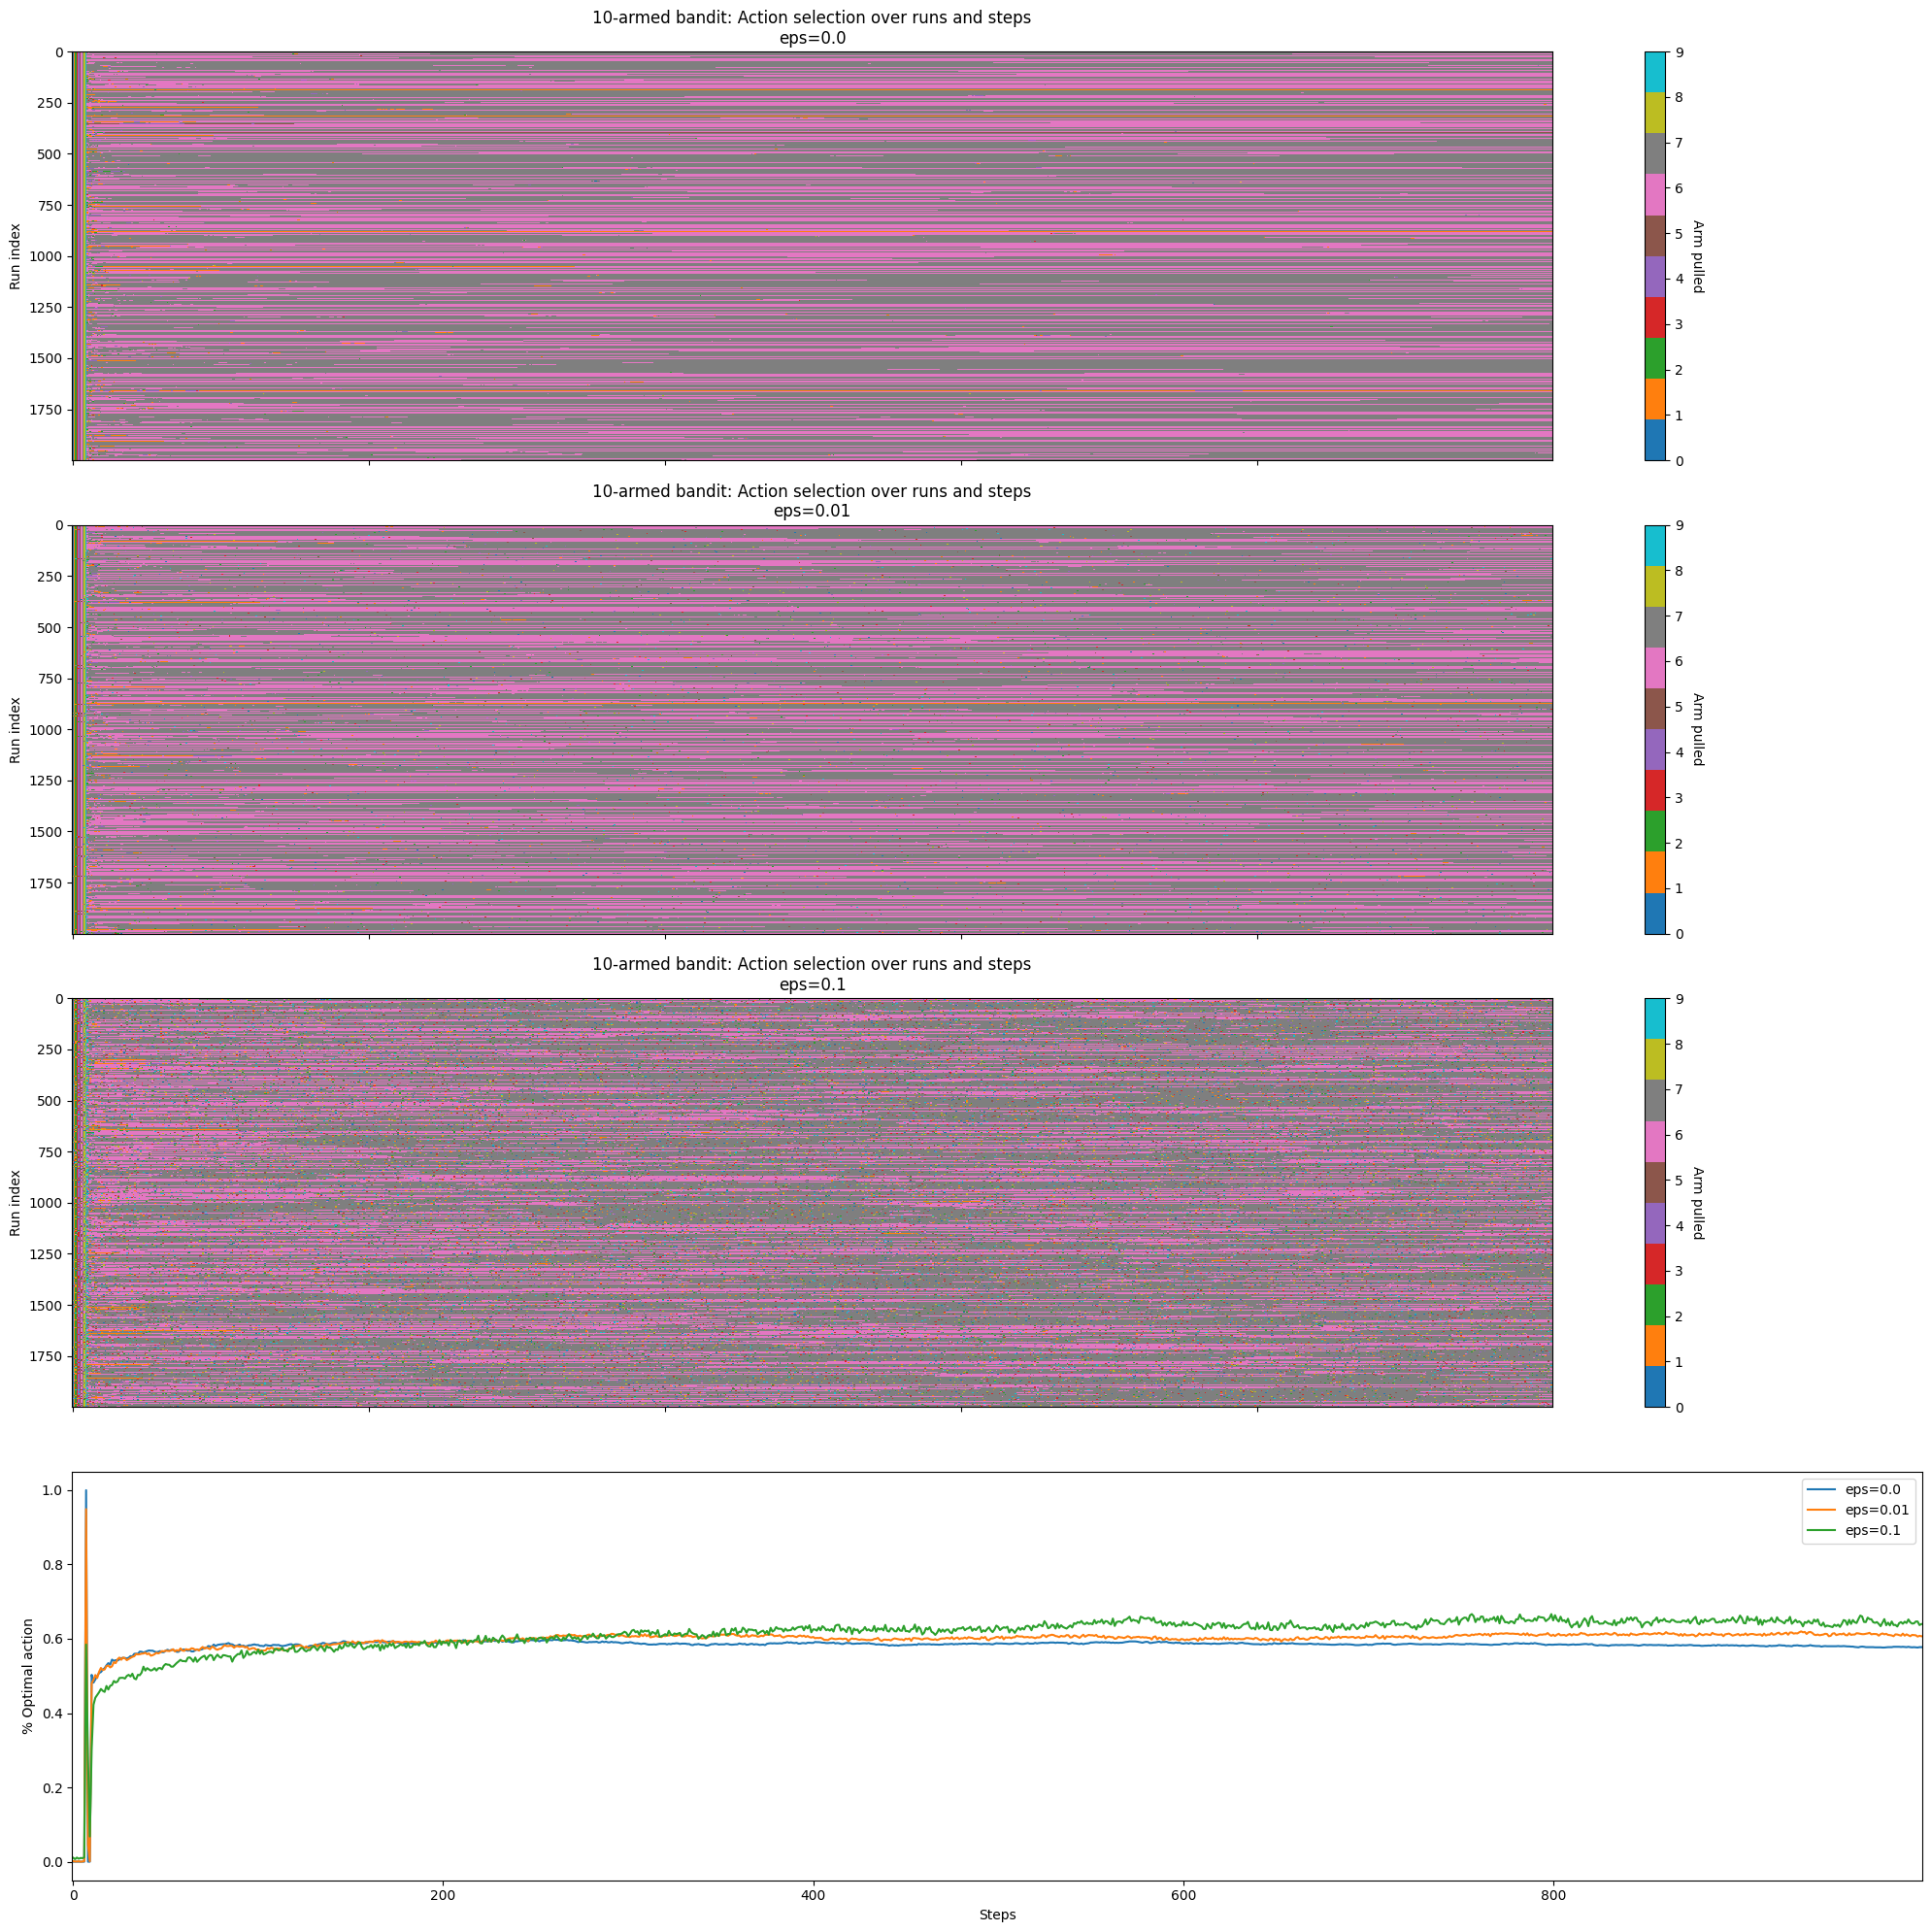

In [25]:
def plot_img(img_data: np.ndarray, k: int, ax: plt.Axes, fig: plt.Figure, title):
    cmap = plt.get_cmap("tab10", k)
    img = ax.imshow(
        img_data, cmap=cmap, aspect="auto", interpolation="nearest", vmin=0, vmax=k - 1
    )
    cbar = fig.colorbar(img, ax=ax, ticks=range(k), orientation="vertical")
    cbar.set_label("Arm pulled", rotation=270, labelpad=15)
    ax.set_ylabel("Run index")
    ax.set_title(title)


layouts = [["A", "A", "A"], ["B", "B", "B"], ["C", "C", "C"], ["D", "D", "D"]]
fig, ax = plt.subplot_mosaic(layouts, figsize=(20, 20), sharex=True)

plot_img(
    exp_a_1,
    k=10,
    ax=ax["A"],
    fig=fig,
    title="10-armed bandit: Action selection over runs and steps\neps=0.0",
)
plot_img(
    exp_a_2,
    k=10,
    ax=ax["B"],
    fig=fig,
    title="10-armed bandit: Action selection over runs and steps\neps=0.01",
)
plot_img(
    exp_a_3,
    k=10,
    ax=ax["C"],
    fig=fig,
    title="10-armed bandit: Action selection over runs and steps\neps=0.1",
)
ax["D"].plot(exp_o_1, label="eps=0.0")
ax["D"].plot(exp_o_2, label="eps=0.01")
ax["D"].plot(exp_o_3, label="eps=0.1")
ax["D"].set_ylabel("% Optimal action")
ax["D"].set_xlabel("Steps")
ax["D"].legend()
plt.tight_layout()
plt.show()